# Jupyter Notebook Demo of CT Lesion annotation

This notebook provides a demo of CT lesion annotation using MedSAM2. Please install MedSAM2 and download the model weights before running the notebook. This notebook uses the box prompt on the key slices to segment the 3D CT lesion case.

In [2]:
# load libraries and define necessary functions
from glob import glob
from tqdm import tqdm
import os
from os.path import join, basename
import re
import matplotlib.pyplot as plt
from collections import OrderedDict
import pandas as pd
import numpy as np
import argparse

from PIL import Image
import SimpleITK as sitk
import torch
import torch.multiprocessing as mp
from sam2.build_sam import build_sam2_video_predictor_npz
import SimpleITK as sitk
from skimage import measure, morphology

torch.set_float32_matmul_precision('high')
torch.manual_seed(2024)
torch.cuda.manual_seed(2024)
np.random.seed(2024)


def getLargestCC(segmentation):
    labels = measure.label(segmentation)
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    return largestCC

def show_mask(mask, ax, mask_color=None, alpha=0.5):
    """
    show mask on the image

    Parameters
    ----------
    mask : numpy.ndarray
        mask of the image
    ax : matplotlib.axes.Axes
        axes to plot the mask
    mask_color : numpy.ndarray
        color of the mask
    alpha : float
        transparency of the mask
    """
    if mask_color is not None:
        color = np.concatenate([mask_color, np.array([alpha])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, alpha])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax, edgecolor='blue'):
    """
    show bounding box on the image

    Parameters
    ----------
    box : numpy.ndarray
        bounding box coordinates in the original image
    ax : matplotlib.axes.Axes
        axes to plot the bounding box
    edgecolor : str
        color of the bounding box
    """
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor=edgecolor, facecolor=(0,0,0,0), lw=2))     


def resize_grayscale_to_rgb_and_resize(array, image_size):
    """
    Resize a 3D grayscale NumPy array to an RGB image and then resize it.
    
    Parameters:
        array (np.ndarray): Input array of shape (d, h, w).
        image_size (int): Desired size for the width and height.
    
    Returns:
        np.ndarray: Resized array of shape (d, 3, image_size, image_size).
    """
    d, h, w = array.shape
    resized_array = np.zeros((d, 3, image_size, image_size))
    
    for i in range(d):
        img_pil = Image.fromarray(array[i].astype(np.uint8))
        img_rgb = img_pil.convert("RGB")
        img_resized = img_rgb.resize((image_size, image_size))
        img_array = np.array(img_resized).transpose(2, 0, 1)  # (3, image_size, image_size)
        resized_array[i] = img_array
    
    return resized_array


Please specify the following:

- `checkpoint`: model checkpoint  
- `imgs_path`: path to the 3D volume in `nii.gz` format  
- `model_cfg`: model config path  
- `pred_save_dir`: path to save the inference results  
- `path_DL_info`: path to the CT lesion key slices info  

In [3]:
# Set paths to the model checkpoint, image directory, and dataset information of the bounding boxes
checkpoint = './checkpoints/MedSAM2_latest.pt'
imgs_path = './data'
model_cfg = "configs/sam2.1_hiera_t512.yaml"
pred_save_dir = "./DeeLesion_results"
os.makedirs("./DeeLesion_results/", exist_ok=True)
path_DL_info = 'CT_DeepLesion/DeepLesion_Dataset_Info.csv'
DL_info = pd.read_csv(path_DL_info)

For the purpose of the demo, we perform segmentation only on a single image in the `imgs_path`.

In [4]:
# Nii file name used for this demo
nii_fname = sorted(os.listdir(imgs_path))[0]

seg_info = OrderedDict()
seg_info['nii_name'] = []
seg_info['key_slice_index'] = []
seg_info['DICOM_windows'] = []

In [8]:
# initialized predictor
predictor = build_sam2_video_predictor_npz(model_cfg, checkpoint)

# get corresponding case info
range_suffix = re.findall(r'\d{3}-\d{3}', nii_fname)[0]
slice_range = range_suffix.split('-')
slice_range = [str(int(s)) for s in slice_range]
slice_range = ', '.join(slice_range)
nii_image = sitk.ReadImage(join(imgs_path, nii_fname))
nii_image_data = sitk.GetArrayFromImage(nii_image)

case_name = re.findall(r'^(\d{6}_\d{2}_\d{2})', nii_fname)[0]
case_df = DL_info[
    DL_info['File_name'].str.contains(case_name) &
    DL_info['Slice_range'].str.contains(slice_range)
].copy()

# initialize the segmentation
segs_3D = np.zeros(nii_image_data.shape, dtype=np.uint8)
# print(segs_3D.shape)

row = case_df.iloc[0]
# get the key slice info and preprocess image
lower_bound, upper_bound = row['DICOM_windows'].split(',')
lower_bound, upper_bound = float(lower_bound), float(upper_bound)
nii_image_data_pre = np.clip(nii_image_data, lower_bound, upper_bound)
nii_image_data_pre = (nii_image_data_pre - np.min(nii_image_data_pre))/(np.max(nii_image_data_pre)-np.min(nii_image_data_pre))*255.0
nii_image_data_pre = np.uint8(nii_image_data_pre)
key_slice_idx = row['Key_slice_index']
key_slice_idx = int(key_slice_idx)
slice_range = row['Slice_range']
slice_idx_start, slice_idx_end = slice_range.split(',')
slice_idx_start, slice_idx_end = int(slice_idx_start), int(slice_idx_end)
bbox_coords = row['Bounding_boxes']
bbox_coords = bbox_coords.split(',')
bbox_coords = [int(float(coord)) for coord in bbox_coords]
#bbox_coords = expand_box(bbox_coords)
bbox = np.array(bbox_coords) # y_min, x_min, y_max, x_max
bbox = np.array([bbox[1], bbox[0], bbox[3], bbox[2]])

# get key slice image
key_slice_idx_offset = key_slice_idx - slice_idx_start
# print(key_slice_idx_offset) #6
# print(key_slice_idx) #109
# print(slice_idx_start) #103
# print(slice_idx_end) #115
key_slice_img = nii_image_data_pre[key_slice_idx_offset, :,:]

img_3D_ori = nii_image_data_pre
print(img_3D_ori.shape)
assert np.max(img_3D_ori) < 256, f'input data should be in range [0, 255], but got {np.unique(img_3D_ori)}'

video_height = key_slice_img.shape[0]
video_width = key_slice_img.shape[1]
img_resized = resize_grayscale_to_rgb_and_resize(img_3D_ori, 512)
img_resized = img_resized / 255.0
img_resized = torch.from_numpy(img_resized).cuda()
img_mean=(0.485, 0.456, 0.406)
img_std=(0.229, 0.224, 0.225)
img_mean = torch.tensor(img_mean, dtype=torch.float32)[:, None, None].cuda()
img_std = torch.tensor(img_std, dtype=torch.float32)[:, None, None].cuda()
img_resized -= img_mean
img_resized /= img_std
z_mids = []

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    inference_state = predictor.init_state(img_resized, video_height, video_width)

    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
                                        inference_state=inference_state,
                                        frame_idx=key_slice_idx_offset,
                                        obj_id=1,
                                        box=bbox,
                                        )


    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
        segs_3D[out_frame_idx, (out_mask_logits[0] > 0.0).cpu().numpy()[0]] = 1
    predictor.reset_state(inference_state)

    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
                                        inference_state=inference_state,
                                        frame_idx=key_slice_idx_offset,
                                        obj_id=1,
                                        box=bbox,
                                    )


    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state, reverse=True):
        segs_3D[out_frame_idx, (out_mask_logits[0] > 0.0).cpu().numpy()[0]] = 1
    predictor.reset_state(inference_state)
if np.max(segs_3D) > 0:
    segs_3D = getLargestCC(segs_3D)
    segs_3D = np.uint8(segs_3D) 
sitk_image = sitk.GetImageFromArray(img_3D_ori)
sitk_image.CopyInformation(nii_image)
sitk_mask = sitk.GetImageFromArray(segs_3D)
sitk_mask.CopyInformation(nii_image)
# save single lesion
key_slice_idx = row['Key_slice_index']
save_seg_name = nii_fname.split('.nii.gz')[0] + f'_k{key_slice_idx}_mask.nii.gz'
sitk.WriteImage(sitk_image, os.path.join(pred_save_dir, nii_fname.replace('.nii.gz', '_img.nii.gz')))
sitk.WriteImage(sitk_mask, os.path.join(pred_save_dir, save_seg_name))
seg_info['nii_name'].append(save_seg_name)
seg_info['key_slice_index'].append(key_slice_idx)
seg_info['DICOM_windows'].append(row['DICOM_windows'])


(13, 512, 512)
6
109
103
115
(13, 512, 512)


propagate in video: 100%|██████████| 7/7 [00:00<00:00, 129.10it/s]


In [6]:
# save the segmentation info to a csv file
seg_info_df = pd.DataFrame(seg_info)
seg_info_df.to_csv(join(pred_save_dir, 'tiny_seg_info202412.csv'), index=False)

# Optional: Realization of the segmentation
In the following, we show the image and the overlayed segmentation slices of 25 percentile, key slice, and 75 percentile

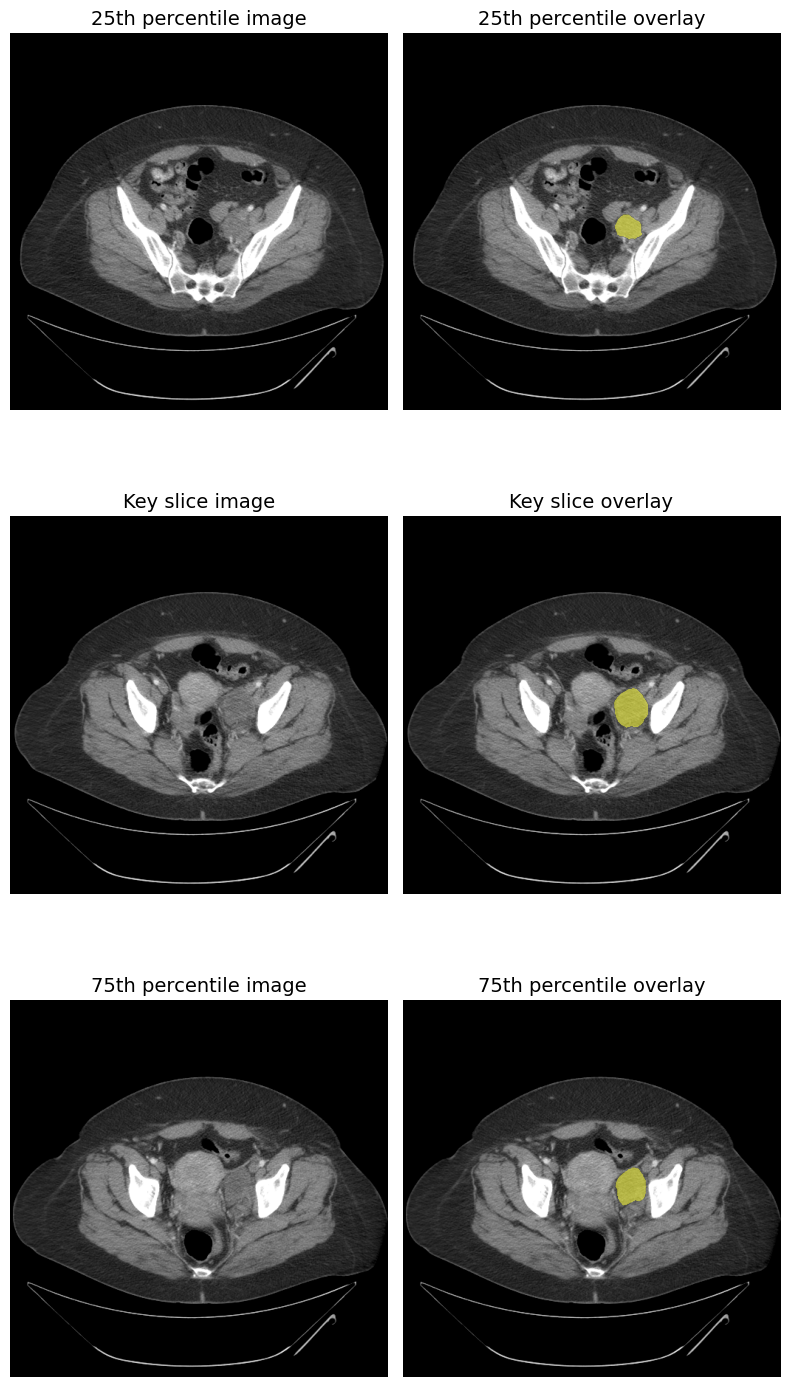

In [24]:
slice_indices = np.arange(0, slice_idx_end - slice_idx_start)
slice_idx_25 = int(np.percentile(slice_indices, 25))
slice_idx_75 = int(np.percentile(slice_indices, 75))
percentile_slices = [slice_idx_25, key_slice_idx_offset, slice_idx_75]

fig, axes = plt.subplots(3, 2, figsize=(8, 15))
for ax in axes.flatten():
    ax.axis('off')

row_titles = ['25th percentile image', 'Key slice image', '75th percentile image']
row_titles_masks = ['25th percentile overlay', 'Key slice overlay', '75th percentile overlay']

for row_idx, slice_idx in enumerate(percentile_slices):
    imgs_2D = img_3D_ori[slice_idx].T
    imgs_2D = imgs_2D[:, :, None].repeat(3, axis=-1)
    segs_2D = segs_3D[slice_idx].T

    axes[row_idx, 0].imshow(imgs_2D, cmap='gray')
    axes[row_idx, 1].imshow(imgs_2D, cmap='gray')
    show_mask(segs_2D, ax=axes[row_idx, 1])

    axes[row_idx, 0].set_title(row_titles[row_idx], fontsize=14)
    axes[row_idx, 1].set_title(row_titles_masks[row_idx], fontsize=14)

plt.tight_layout()